In [13]:
import pandas as pd

df=pd.read_csv(r"/content/Social_Network_Ads.csv")
print(df.head())

    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0


In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB
None


Performing EDA:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='count', ylabel='Gender'>

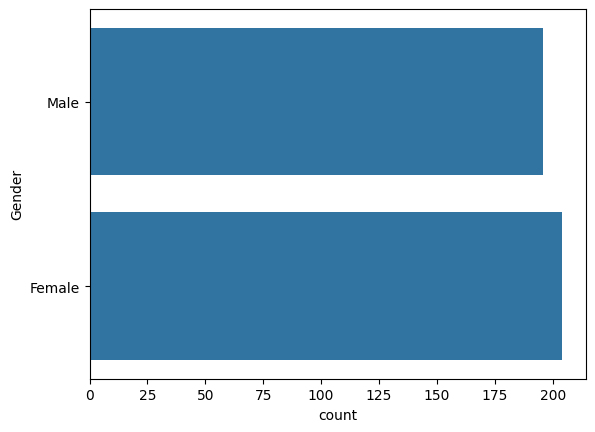

In [3]:
sns.countplot(df['Gender'])

Thus the customers for the product seem to be equally distributed in gender

In [5]:
print(df[(df['Gender']=='Male') & (df['Purchased']==1)].nunique())

User ID            66
Gender              1
Age                28
EstimatedSalary    51
Purchased           1
dtype: int64


<Axes: ylabel='Frequency'>

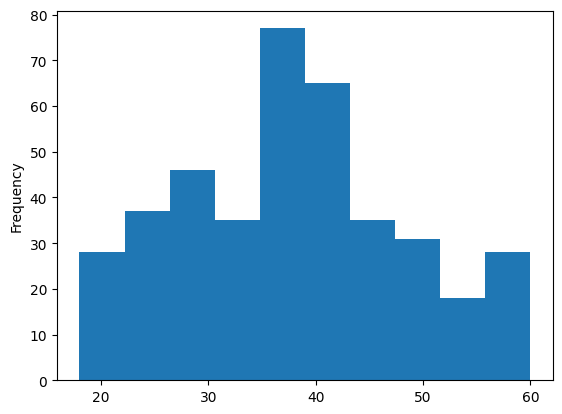

In [9]:
df['Age'].plot(kind='hist')

The age follows a somewhat normal distribution, and so do salaries

---




<Axes: xlabel='EstimatedSalary', ylabel='Density'>

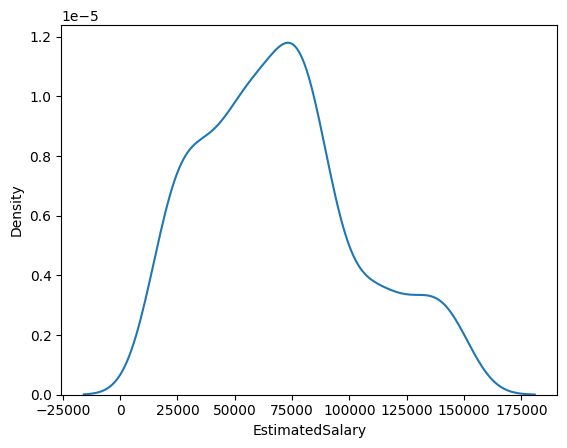

In [10]:
sns.kdeplot(df['EstimatedSalary'])

<Axes: xlabel='count', ylabel='Purchased'>

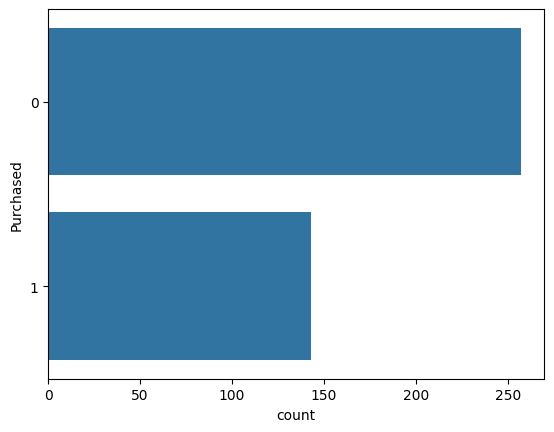

In [12]:
sns.countplot(df['Purchased'].astype('category'))

Thus the output column does not have a major imbalance, and we can now proceed with the data preprocessing


<Axes: xlabel='EstimatedSalary', ylabel='Age'>

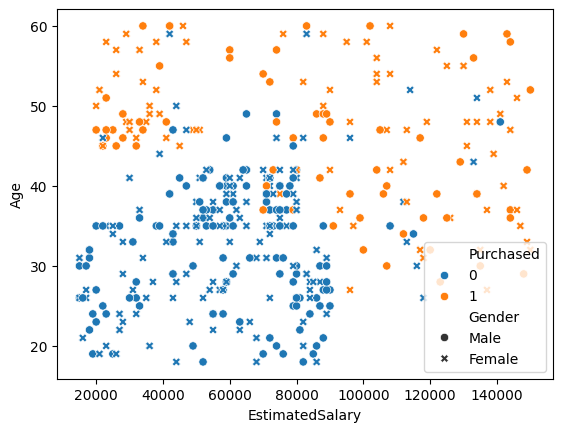

In [15]:
sns.scatterplot(data=df, x='EstimatedSalary', y='Age', hue='Purchased', style='Gender')

This is the graph which makes the algorithm intuitive- the categories seem to be very clearly divided by lines which are parallel to the x and y axes- thus the model to be trained for this data is Decision Tree

In [18]:
df['Gender']=df['Gender'].map({'Female':0, 'Male':1})

In [19]:
from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler()
sc.fit_transform(df)
X=df.drop(columns=['User ID', 'Purchased'])
y=df['Purchased']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42, test_size=0.2)
X_train.head()

,Gender,Age,EstimatedSalary
3,0,27,57000
18,1,46,28000
202,0,39,134000
250,0,44,39000
274,0,57,26000


Trying both decision tree as well as random forest to get the most accurate model:

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [22]:
dt=DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=2)
dt.fit(X_train, y_train)
y_pred=dt.predict(X_test)
print(cross_val_score(dt, X, y, cv=18, scoring='accuracy').mean())

0.8996486605182257


Plotting the decision tree so that we can see the divisions it is doing:

[Text(0.5416666666666666, 0.875, 'x[1] <= 44.5\ngini = 0.46\nsamples = 320\nvalue = [205, 115]'),
 Text(0.3333333333333333, 0.625, 'x[2] <= 90500.0\ngini = 0.3\nsamples = 234\nvalue = [191, 43]'),
 Text(0.4375, 0.75, 'True  '),
 Text(0.16666666666666666, 0.375, 'x[1] <= 36.5\ngini = 0.07\nsamples = 193\nvalue = [186.0, 7.0]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.0\nsamples = 126\nvalue = [126, 0]'),
 Text(0.25, 0.125, 'gini = 0.187\nsamples = 67\nvalue = [60, 7]'),
 Text(0.5, 0.375, 'x[2] <= 133500.0\ngini = 0.214\nsamples = 41\nvalue = [5, 36]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.293\nsamples = 28\nvalue = [5, 23]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]'),
 Text(0.75, 0.625, 'x[2] <= 40500.0\ngini = 0.273\nsamples = 86\nvalue = [14.0, 72.0]'),
 Text(0.6458333333333333, 0.75, '  False'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 27\nvalue = [0, 27]'),
 Text(0.8333333333333334, 0.375, 'x[2] <= 84500.0\ngini = 0.362\ns

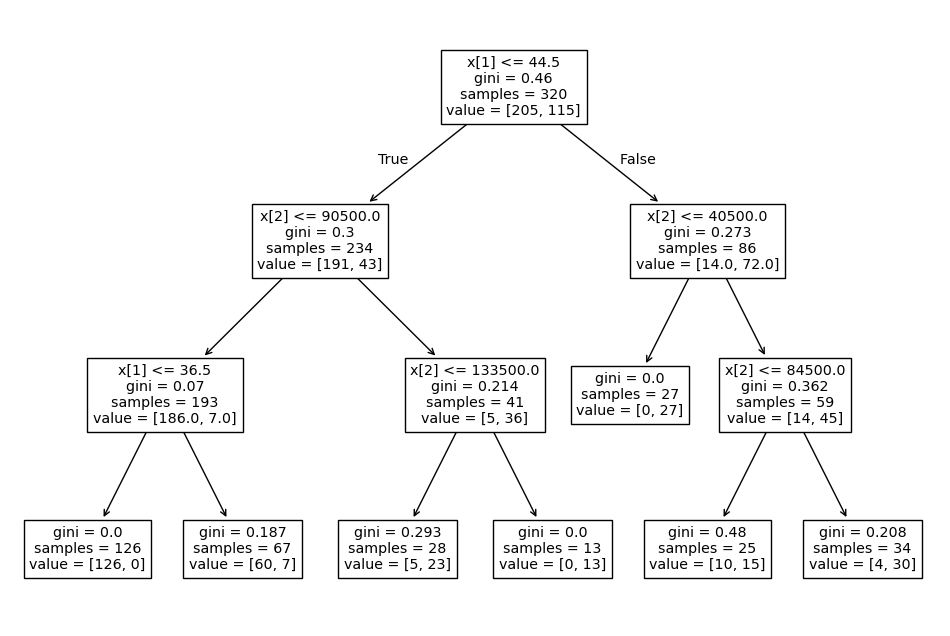

In [23]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12,8))
plot_tree(dt.fit(X_train, y_train))

In [24]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

[[47  5]
 [ 2 26]]
0.8813559322033898


In [25]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred2=rf.predict(X_test)
print(cross_val_score(rf, X,y,cv=18, scoring='accuracy').mean())

0.8774703557312252


As we can see Decision Trees are already giving better results in this classification problem. We perform hyperparameter tuning for this decision tree so that we can further improve the results

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred_best))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
0.9125


Hyperparameter tuning further improves the results of this classification by 0.3, so this decision tree is taken as the final model for this problem.

In [28]:
import pickle
pickle.dump(dt, open('model.pkl', 'wb'))